<a href="https://colab.research.google.com/github/dmat/fakenewsdetection/blob/main/FakeNewsDetection_Glove_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchtext==0.8.0
!pip install torch==1.7

     |████████████████████████████████| 6.9MB 6.6MB/s 
  Found existing installation: torchtext 0.7.0
    Uninstalling torchtext-0.7.0:
      Successfully uninstalled torchtext-0.7.0
     |████████████████████████████████| 776.7MB 20kB/s 
  Found existing installation: torch 1.6.0
    Uninstalling torch-1.6.0:
      Successfully uninstalled torch-1.6.0


In [1]:
# For local run
data_path = 'data/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/SML/fake news detection/'

Mounted at /content/drive


In [3]:
# Libraries
import pandas as pd 
import matplotlib.pyplot as plt
#deal with tensors
import torch   

#handling text data
from torchtext import data 

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns

In [4]:
#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Dec 18 00:05:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import string
def remove_punctuation(x):
  aux = ''.join(ch for ch in x if ch not in set(string.punctuation))
  return aux

In [ ]:
# load the training and testing data
data_train = pd.read_csv(data_path + 'fnn_train.csv')
data_test = pd.read_csv(data_path + 'fnn_test.csv')
data_val = pd.read_csv(data_path + 'fnn_dev.csv')

In [ ]:
# convert the data labels into categorical variables (real = 0, fake = 1)
data_train["label_fnn"] = data_train["label_fnn"].replace("real",0)
data_train["label_fnn"] = data_train["label_fnn"].replace("fake",1)
data_test["label_fnn"] = data_test["label_fnn"].replace("real",0)
data_test["label_fnn"] = data_test["label_fnn"].replace("fake",1)
data_val["label_fnn"] = data_val["label_fnn"].replace("real",0)
data_val["label_fnn"] = data_val["label_fnn"].replace("fake",1)

data_train = data_train.drop("date", axis=1)
data_test = data_test.drop("date", axis=1)
data_val = data_val.drop("date", axis=1)
data_train = data_train.drop(["speaker"],axis=1)
data_test = data_test.drop(["speaker"],axis=1)
data_val = data_val.drop(["speaker"],axis=1)
data_train_csv = data_train.drop(["sources"],axis=1)
data_test_csv = data_test.drop(["sources"],axis=1)
data_val_csv = data_val.drop(["sources"],axis=1)
data_train_csv = data_train_csv.rename(columns={"fullText_based_content": "text","label_fnn": "label"}, errors="raise")
data_test_csv = data_test_csv.rename(columns={"fullText_based_content": "text","label_fnn": "label"}, errors="raise")
data_val_csv = data_val_csv.rename(columns={"fullText_based_content": "text","label_fnn": "label"}, errors="raise")

#Remove punctuations
data_train_csv['text'] = data_train_csv['text'].apply(remove_punctuation)
data_test_csv['text'] = data_test_csv['text'].apply(remove_punctuation)
data_val_csv['text'] = data_val_csv['text'].apply(remove_punctuation)

data_train_csv.to_csv(data_path + r'fnn_train_clean.csv', index = False)
data_test_csv.to_csv(data_path + r'fnn_test_clean.csv', index = False)
data_val_csv.to_csv(data_path + r'fnn_val_clean.csv', index = False)

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:

LABEL = data.LabelField(dtype = torch.float) 
#For LSTM
TEXT = data.Field(tokenize='spacy', include_lengths=True, batch_first=True, lower=True,  stop_words = stop_words)

#For NN with Bigram
# TEXT = data.Field(tokenize='spacy', lower=True, preprocessing = generate_bigrams,  stop_words = stop_words)

fields = [('id:',None), ('statement:',None), ('paragraph_based_content',None),
      ('text', TEXT),('label',LABEL)]

In [33]:
news_data = data.TabularDataset(
        path= data_path+ "fnn_train_clean.csv", 
        format="CSV", 
        fields=fields,
        skip_header=True)

print(vars(news_data.examples[1]))

{'text': ['supreme', 'court', 'justices', 'embarked', 'three', 'days', 'oral', 'arguments', 'historic', 'lawsuit', 'health', 'care', 'law', 'gov', 'rick', 'scott', 'went', 'national', 'tv', 'media', 'blitz', 'said', 'one', 'regurgitated', 'falsehoods', 'health', 'care', 'debate', '\n', 'ran', 'campaign', 'getting', 'state', 'back', 'work', 'biggest', 'jobkiller', 'ever', 'said', 'fox', 'friends', 'march', '26', '2012', 'mean', 'think', 'government', 'ca', 'n’t', 'buy', 'health', 'care', 'cheaper', 'anybody', 'else', 'unbelievable', 'penalties', 'go', '\n', 'big', 'jobkiller', 'cost', 'much', 'said', '\n', 'politifact', 'examined', 'similar', 'claims', 'law', '’s', 'jobkilling', 'effect', 'house', 'republican', 'leader', 'eric', 'cantor', ' ', 'us', 'chamber', 'commerce', 'former', 'us', 'senate', 'candidate', 'former', 'florida', 'house', 'majority', 'leader', 'adam', 'hasner', ' ', 'none', 'fared', 'well', 'truthometer', '\n', 'wanted', 'rule', 'scott', '’s', 'statement', 'given', 're

In [34]:
test_data = data.TabularDataset(
        path= data_path + "fnn_test_clean.csv", 
        format="CSV", 
        fields=fields,
        skip_header=True)

print(vars(test_data.examples[1]))

{'text': ['abcs', 'week', 'chairmen', 'republican', 'democratic', ' ', 'national', 'parties', 'debated', 'significance', 'republican', 'charles', 'djous', ' ', 'victory', 'hawaii', 'congressional', 'special', 'election', 'may', '22', '2010', ' ', ' ', 'first', 'time', 'republican', 'represent', 'hawaii', 'congress', 'since', '1991', '\n', 'rnc', ' ', 'chairman', 'michael', 'steele', 'called', 'victory', 'significant', 'given', 'hawaiis', ' ', 'penchant', 'supporting', 'democrats', 'noted', 'state', ' ', 'birthplace', 'president', 'barack', 'obama', 'sorry', 'birthers', '\n', ' ', 'course', 'dnc', 'chairman', 'tim', 'kaine', 'different', 'read', 'said', 'djous', ' ', 'victory', 'unique', 'circumstances', 'special', 'election', ' ', 'called', 'replace', 'resigning', 'rep', 'neil', 'abercrombie', 'regular', 'fall', 'election', '   ', 'political', 'mood', 'swing', 'hawaii', 'special', 'election', ' ', 'include', 'primary', 'meant', 'parties', 'could', 'field', 'multiple', 'candidates', ' '

In [ ]:
valid_data = data.TabularDataset(
        path= data_path + "fnn_val_clean.csv", 
        format="CSV", 
        fields=fields,
        skip_header=True)

print(vars(test_data.examples[1]))

{'text': ['abcs', 'week', 'chairmen', 'republican', 'democratic', ' ', 'national', 'parties', 'debated', 'significance', 'republican', 'charles', 'djous', ' ', 'victory', 'hawaii', 'congressional', 'special', 'election', 'may', '22', '2010', ' ', ' ', 'first', 'time', 'republican', 'represent', 'hawaii', 'congress', 'since', '1991', '\n', 'rnc', ' ', 'chairman', 'michael', 'steele', 'called', 'victory', 'significant', 'given', 'hawaiis', ' ', 'penchant', 'supporting', 'democrats', 'noted', 'state', ' ', 'birthplace', 'president', 'barack', 'obama', 'sorry', 'birthers', '\n', ' ', 'course', 'dnc', 'chairman', 'tim', 'kaine', 'different', 'read', 'said', 'djous', ' ', 'victory', 'unique', 'circumstances', 'special', 'election', ' ', 'called', 'replace', 'resigning', 'rep', 'neil', 'abercrombie', 'regular', 'fall', 'election', '   ', 'political', 'mood', 'swing', 'hawaii', 'special', 'election', ' ', 'include', 'primary', 'meant', 'parties', 'could', 'field', 'multiple', 'candidates', ' '

In [89]:
import random

(train_data, valid_data, test_data)=news_data.split(split_ratio=[0.6,0.2,0.2], random_state = random.seed(SEED))

# (len(train_data),len(valid_data))
# train_data = news_data

In [ ]:
vocab_size = 25000

#For 300D GloVe
# TEXT.build_vocab(train_data, max_size = vocab_size, vectors = "glove.42B.300d", unk_init = torch.Tensor.normal_)  


TEXT.build_vocab(train_data, max_size = vocab_size, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
# print(TEXT.vocab.stoi)

In [91]:
#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)


In [92]:
import torch.nn as nn
class FakeNewsANN(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, output_dim)
        #activation function
        # Uncomment if Loss function is not BCEWithLogitsLoss
        # self.act = nn.Sigmoid()

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        dense_outputs = self.fc(embedded)
        #Final activation function
        # Uncomment if Loss function is not BCEWithLogitsLoss
        # outputs=self.act(dense_outputs)
        
        return dense_outputs        

In [93]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100 
# 100

dropout = 0.2
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

#instantiate the model
model = FakeNewsANN(size_of_vocab, embedding_dim, num_output_nodes)

In [94]:
#architecture
print(model)
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The LSTM model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

FakeNewsANN(
  (embedding): EmbeddingBag(25002, 100, mode=mean)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
The LSTM model has 2,500,301 trainable parameters
torch.Size([25002, 100])


In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

In [96]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

#define metric
def binary_accuracy(preds, y):
    # #round predictions to the closest in
    # rounded_preds = torch.round(torch.sigmoid(preds))
    
    # correct = (rounded_preds == y).float() 
    # acc = correct.sum() / len(correct)
    # return acc
    precision,recall,fscore,support=score(y,preds,average='micro')
    return fscore
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [97]:
def train(model, iterator, optimizer, criterion):
    y_pred = []
    y_true = []   
    threshold=0.5

    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        labels = batch.label
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze(1)  
        # predictions = model(batch.text).squeeze(1)  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        # acc = binary_accuracy(predictions, batch.label)   
        output = (predictions > threshold).int()
        y_pred.extend(output.tolist())
        y_true.extend(labels.tolist())        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        # epoch_acc += acc.item()    
    epoch_acc = binary_accuracy(y_pred, y_true) 
    return epoch_loss / len(iterator), epoch_acc

In [98]:
def evaluate(model, iterator, criterion):
    y_pred = []
    y_true = []    
    threshold=0.5

    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            labels = batch.label
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze(1)
            # predictions = model(batch.text).squeeze(1)
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            # acc = binary_accuracy(predictions, batch.label)
            output = (predictions > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())        

            #keep track of loss and accuracy
            epoch_loss += loss.item()
            # epoch_acc += acc.item()
    epoch_acc = binary_accuracy(y_pred, y_true)     
    return epoch_loss / len(iterator), epoch_acc

In [99]:
N_EPOCHS = 10
best_valid_loss = float('inf')
best_valid_acc = float('inf')
best_train_acc = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    #evaluate the model
    # valid_loss, valid_acc = train(model, valid_iterator, optimizer, criterion)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_train_acc = train_acc
        torch.save(model.state_dict(), data_path + 'saved_fnn_weights_ffn_100d.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.683 | Train Acc: 50.16%
	 Val. Loss: 0.668 |  Val. Acc: 50.97%
	Train Loss: 0.658 | Train Acc: 52.22%
	 Val. Loss: 0.643 |  Val. Acc: 55.50%
	Train Loss: 0.632 | Train Acc: 57.82%
	 Val. Loss: 0.624 |  Val. Acc: 59.65%
	Train Loss: 0.606 | Train Acc: 61.97%
	 Val. Loss: 0.610 |  Val. Acc: 60.11%
	Train Loss: 0.582 | Train Acc: 64.60%
	 Val. Loss: 0.598 |  Val. Acc: 63.26%
	Train Loss: 0.555 | Train Acc: 67.49%
	 Val. Loss: 0.590 |  Val. Acc: 66.12%
	Train Loss: 0.528 | Train Acc: 71.38%
	 Val. Loss: 0.582 |  Val. Acc: 64.67%
	Train Loss: 0.499 | Train Acc: 73.78%
	 Val. Loss: 0.577 |  Val. Acc: 66.28%
	Train Loss: 0.470 | Train Acc: 77.12%
	 Val. Loss: 0.573 |  Val. Acc: 67.20%
	Train Loss: 0.441 | Train Acc: 79.39%
	 Val. Loss: 0.573 |  Val. Acc: 68.32%


Classification Report:
              precision    recall  f1-score   support

           0     0.6514    0.7931    0.7153      1503
           1     0.7434    0.5854    0.6550      1539

    accuracy                         0.6880      3042
   macro avg     0.6974    0.6893    0.6852      3042
weighted avg     0.6979    0.6880    0.6848      3042



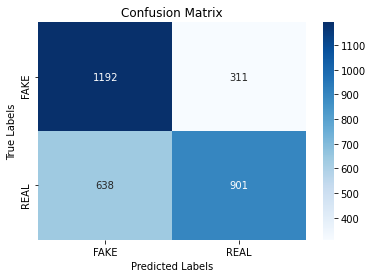

In [100]:
# Test Function

def test(model, iterator, threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            labels = batch.label

            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze(1)

            output = (predictions > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
path= data_path + 'saved_fnn_weights_ffn_100d.pt'
model.load_state_dict(torch.load(path));
test(model, test_iterator)